### Group Project 4 : Comparing 3 Models for Predicting Recidivism

For background on this project, please see the [README](../README.md).

**Notebooks**
- [Data Acquisition & Cleaning](./01_data_acq_clean.ipynb)
- [Exploratory Data Analysis](./02_eda.ipynb)
- [Modeling](./03_modeling.ipynb)
- Experiments (this notebook)
- [Results and Recommendations](./04_results.ipynb)

**In this notebook, you'll find:**
- TODO etc.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import balanced_accuracy_score, ConfusionMatrixDisplay, recall_score, f1_score, precision_score, confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
# from imblearn.over_sampling import ADASYN

**Model 1: Base feature set - New York**

**Model 2: Criminal history feature set - Florida**

- We're going to try vectorizing each person's list of charges and incorporating some NLP into our production model.
- We'll use TFIDF vectorization, and before merging the NLP columns into our production model, we'll use a GridSearch with a simple LogisticRegression to
determine the best parameters to use for TFIDF.

In [40]:
fl = pd.read_csv('../data/FL/FL_final.csv')

# drop all non-model columns - keeping agg_charges this time!
fl = fl.drop(columns = [
    'person_id',  # unique ID, not predictive
    'avg_days_between_offenses', 'avg_days_between_arrests', # only meaningful for recidivists
    'age_at_last_incarceration', 'age_at_last_release', 'age_at_last_arrest', # "last" columns are not predictive
] + [col for col in fl if col.startswith('comp_')] # not using COMPAS scores in the model
  + [col for col in fl if col.startswith('last_charge_')] # last charges are not predictive
)

In [41]:
# define X and y, train-test split
nlp = fl[['agg_charges', 'recidivism']].dropna()
X = nlp['agg_charges']
y = nlp['recidivism']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, stratify = y)

# Pipeline with logreg
pipe = Pipeline(steps = [('tfidf', TfidfVectorizer()), ('logreg', LogisticRegression(max_iter = 10_000))])

pipe_params = {
    'tfidf__stop_words': [None, 'english'],
    'tfidf__max_features': [3000, 4000],
    'tfidf__min_df': [1, 2],
    'tfidf__max_df': [0.8, 0.9],
    'tfidf__ngram_range': [(1, 1), (1, 2)]
}

# search
gs = GridSearchCV(estimator = pipe, param_grid = pipe_params, n_jobs = -1)
gs.fit(X_train, y_train)

# score
model = gs.best_estimator_
preds = model.predict(X_test)

train_acc = model.score(X_train, y_train)
test_acc = model.score(X_test, y_test)
recall = recall_score(y_test, preds, pos_label = 1)
precision = precision_score(y_test, preds, pos_label = 1)
f1 = f1_score(y_test, preds, pos_label = 1)

print(f'training set accuracy: {train_acc}')
print(f'test set accuracy: {test_acc}')
print(f'recall: {recall}')
print(f'precision: {precision}')
print(f'f1 score: {f1}')

training set accuracy: 0.787673806839534
test set accuracy: 0.7550713749060857
recall: 0.6057416267942584
precision: 0.7250859106529209
f1 score: 0.6600625651720542


In [42]:
# what were our best parameters?
model

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_df=0.8, max_features=3000,
                                 ngram_range=(1, 2), stop_words='english')),
                ('logreg', LogisticRegression(max_iter=10000))])

In [43]:
# now we can apply our optimal vectorization
tfidf = TfidfVectorizer(max_df = 0.8, max_features = 3000, ngram_range = (1, 2), stop_words = 'english')
nlpcols = tfidf.fit_transform(fl['agg_charges'])

In [54]:
# and add the vectorized columns to our main dataframe
fl_nlp = pd.concat([fl, pd.DataFrame(nlpcols.todense(), columns = tfidf.get_feature_names_out())], axis = 1)

In [58]:
# define our final X and y, train-test split
X = fl_nlp.drop(columns = ['recidivism', 'agg_charges'])
y = fl_nlp['recidivism']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, stratify = y)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

# and scale
ss = StandardScaler()
X_train_sc = ss.fit_transform(X_train)
X_test_sc = ss.transform(X_test)

# and rebalance
adasyn = ADASYN(random_state = 42, sampling_strategy = 1.0)
X_train_sc, y_train = adasyn.fit_resample(X_train_sc, y_train)

In [59]:
X_train.shape

(7983, 3032)

84/84 [==============================] - 0s 1ms/step
training set accuracy: 0.9577807188034058
test set accuracy: 0.7498121857643127
recall: 0.6775119617224881
precision: 0.682738669238187
f1 score: 0.6801152737752162


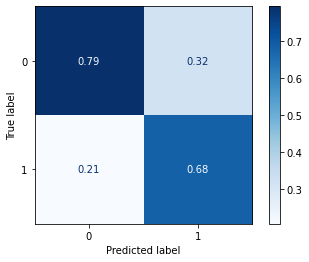

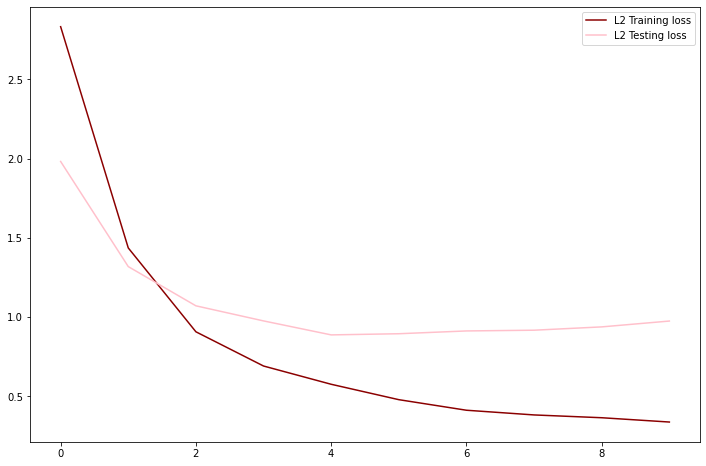

In [62]:
# L2-regularized FNN with early stopping
es = EarlyStopping(patience = 5)

# Model
model = Sequential()
model.add(Dense(units = 128, activation = 'relu', input_shape = (3032, ),
    kernel_regularizer = l2(0.01)))
model.add(Dense(units = 64, activation = 'relu', kernel_regularizer = l2(0.01)))
model.add(Dense(units = 1, activation = 'sigmoid'))

# Compile it
model.compile(optimizer = 'adam', loss = 'bce', metrics = ['acc'])

# Fit it
res = model.fit(x = X_train_sc, y = y_train, validation_data = (X_test_sc, y_test),
    epochs = 100, batch_size = 256, verbose = 0, callbacks = [es])

# Scores
train_acc = res.history['acc'][-1]
test_acc = res.history['val_acc'][-1]
preds = pd.Series(model.predict(X_test_sc)[:, 0]).map(lambda x: 1 if x >= 0.5 else 0)
recall = recall_score(y_test, preds, pos_label = 1)
precision = precision_score(y_test, preds, pos_label = 1)
f1 = f1_score(y_test, preds, pos_label = 1)
print(f'training set accuracy: {train_acc}')
print(f'test set accuracy: {test_acc}')
print(f'recall: {recall}')
print(f'precision: {precision}')
print(f'f1 score: {f1}')

ConfusionMatrixDisplay.from_predictions(y_test, preds, normalize = 'pred', cmap='Blues')

# Visualize
train_loss_l2 = res.history['loss']
test_loss_l2 = res.history['val_loss']

plt.figure(figsize=(12, 8))
plt.plot(train_loss_l2, label='L2 Training loss', color='darkred')
plt.plot(test_loss_l2, label='L2 Testing loss', color='pink')
plt.legend();

CONCLUSIONS
- Looks like adding the NLP columns to the production model causes pretty major overfitting - possibly the result of trying such high-dimensional data with a neural network.
- We won't use the NLP columns. Worthwhile experiment though!

**Model 3: Behavioral feature set - Georgia**

- We're going build a model using only the most important features identified during the model trials, in the hopes reducing some of the noise and improving our accuracy.

In [10]:
# Imports

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, BaggingClassifier 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [5]:
# Reading in necessary files
ga_dummy = pd.read_csv('../data/GA/georgia_dummy.csv')
feats = pd.read_csv('../data/GA/important_feats.csv')

In [6]:
# Merging dataframes to include only the important features and target column

important_feats = feats.loc[(feats['coef'] > 1.15) | (feats['coef'] < 0.85)]

important_cols = [col for col in important_feats['feature']]

ga_exper = ga_dummy[important_cols]
ga_exper = ga_exper.join(ga_dummy['recidivism_within_3years'])
ga_exper

,gender_male,gang_affiliated,condition_mh_sa,violations_electronicmonitoring,violations_instruction,drugtests_thc_positive,percent_days_employed,age_at_release_18-22,age_at_release_23-27,age_at_release_38-42,age_at_release_43-47,age_at_release_48 or older,education_level_at least some college,education_level_less than hs diploma,prison_years_greater than 2 to 3 years,prison_years_more than 3 years,recidivism_within_3years
0,1,0,1,0,0,0.000000,0.488562,0,0,0,1,0,1,0,0,1,0
1,1,0,0,0,1,0.000000,0.425234,0,0,0,0,0,0,1,0,1,1
2,1,0,1,0,1,0.333333,0.000000,0,0,0,0,1,1,0,0,0,1
3,1,0,1,0,0,0.000000,1.000000,0,0,1,0,0,0,1,0,0,0
4,1,0,1,0,0,0.000000,0.203562,0,0,0,0,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24421,1,0,0,0,0,0.000000,0.189507,0,1,0,0,0,1,0,0,1,1
24422,1,0,0,0,0,0.000000,0.757098,0,0,1,0,0,1,0,0,1,1
24423,1,0,0,1,0,0.000000,0.711138,0,0,0,0,0,1,0,0,1,1
24424,0,0,0,0,0,0.000000,0.000000,0,0,0,0,0,1,0,0,1,0


---
## Building a Function to Streamline Modeling

In [32]:
model_experiments_df = pd.DataFrame(columns=['model_used', 'train_score', 'test_score',
'accuracy', 'specificity', 'precision', 'recall', 'f1 score', 'true_neg', 'false_pos', 'false_neg', 'true_pos'])

In [33]:
def model_expers(model, model_id):

    '''Setting X and y, and fitting the model'''
    X = ga_exper.drop(columns='recidivism_within_3years')
    y = ga_exper['recidivism_within_3years']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42, stratify=y)
    model.fit(X_train, y_train)
    train_score = model.score(X_train, y_train)
    test_score = model.score(X_test, y_test)

    '''Baseline calculation for reference in the returned confusion matrix'''
    baseline = y.value_counts(normalize=True)[1]

    '''Calculating classification rates'''
    preds = model.predict(X_test)
    tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()
    acc = (tp + tn) / (tn + fp + tp + fn)
    spec = tn / (tn + fp)
    prec = tp / (tp + fp)
    recall = tp / (tp + fn)
    f1 = ((prec * recall) / (prec + recall)) * 2

    '''Adding all values to the model_trials dataframe'''
    model_list = [model_id, train_score, test_score, acc, spec, prec, recall, f1, tn, fp, fn, tp]
    model_experiments_df.loc[len(model_experiments_df.index)] = model_list

    '''Output will show scores and classification metrics'''
    print(model_id)
    print(f'Training Score: {round(train_score, 4)}')
    print(f'Testing Score: {round(test_score, 4)} \n')
    print(f'Accuracy: {round(acc, 4)}')
    print(f'Specificity: {round(spec, 4)}')
    print(f'Precision: {round(prec, 4)}')
    print(f'Recall: {round(recall, 4)}')
    print(f'F1 Score: {round(f1, 4)} \n')

    '''Returning a confusion matrix colored based on performance against the baseline'''
    print('Best accuracy rate confusion matrix:')
    if acc > baseline:
        return ConfusionMatrixDisplay.from_estimator(model, X_test, y_test, cmap='viridis', values_format='d');
    else: 
        return ConfusionMatrixDisplay.from_estimator(model, X_test, y_test, cmap='magma', values_format='d');

Gradient Boosting
Training Score: 0.696
Testing Score: 0.6762 

Accuracy: 0.6762
Specificity: 0.535
Precision: 0.7104
Recall: 0.7718
F1 Score: 0.7398 

Best accuracy rate confusion matrix:


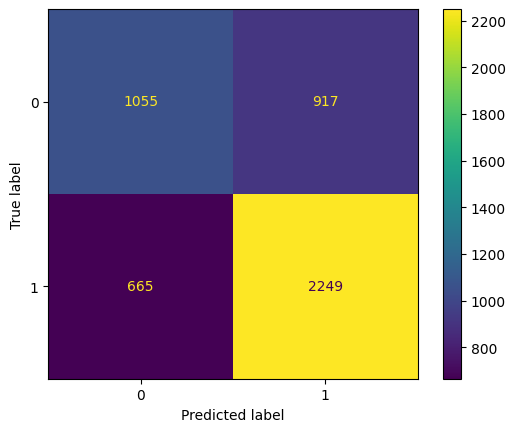

In [34]:
gb = GradientBoostingClassifier(random_state=42)

model_expers(gb, 'Gradient Boosting')

Logistic Regression
Training Score: 0.6802
Testing Score: 0.6701 

Accuracy: 0.6701
Specificity: 0.5117
Precision: 0.7017
Recall: 0.7773
F1 Score: 0.7375 

Best accuracy rate confusion matrix:


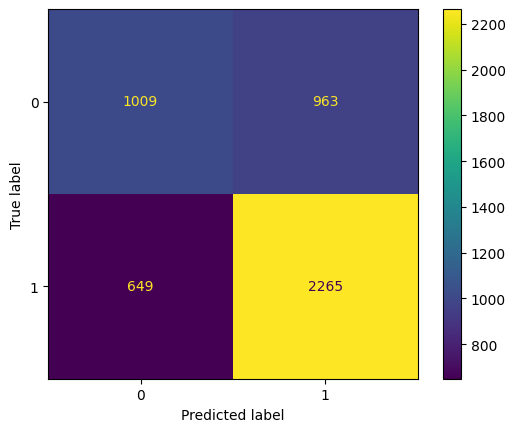

In [35]:
lr = LogisticRegression(random_state=42)

model_expers(lr, 'Logistic Regression')

KNN
Training Score: 0.7289
Testing Score: 0.6318 

Accuracy: 0.6318
Specificity: 0.5122
Precision: 0.6834
Recall: 0.7128
F1 Score: 0.6978 

Best accuracy rate confusion matrix:


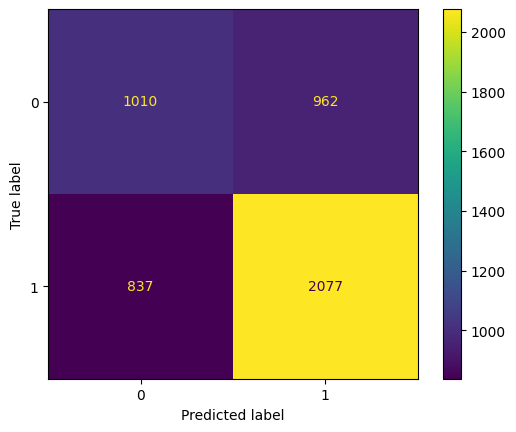

In [36]:
knn = Pipeline([
    ('ss', StandardScaler()),
    ('knn', KNeighborsClassifier())
])

model_expers(knn, 'KNN')    

Random Forest
Training Score: 0.8805
Testing Score: 0.6279 

Accuracy: 0.6279
Specificity: 0.4746
Precision: 0.673
Recall: 0.7316
F1 Score: 0.7011 

Best accuracy rate confusion matrix:


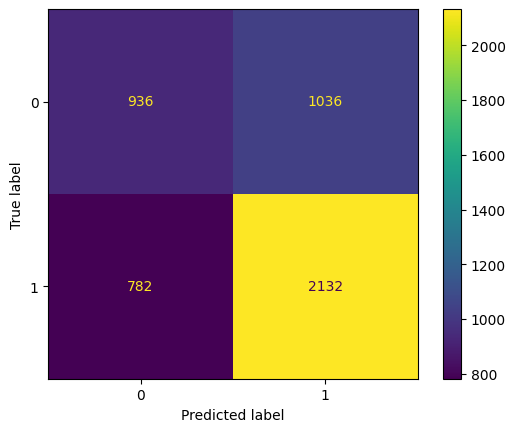

In [37]:
rf = RandomForestClassifier(random_state=42)

model_expers(rf, 'Random Forest')

Ada Boost
Training Score: 0.6885
Testing Score: 0.6758 

Accuracy: 0.6758
Specificity: 0.5446
Precision: 0.7127
Recall: 0.7646
F1 Score: 0.7377 

Best accuracy rate confusion matrix:


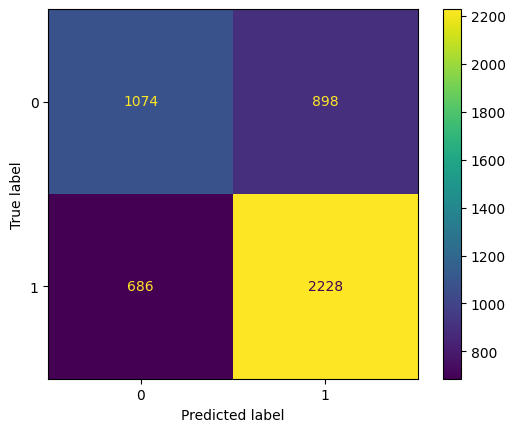

In [38]:
ada = AdaBoostClassifier(random_state=42)

model_expers(ada, 'Ada Boost')

MultinomialNB
Training Score: 0.6536
Testing Score: 0.651 

Accuracy: 0.651
Specificity: 0.4143
Precision: 0.6718
Recall: 0.8113
F1 Score: 0.735 

Best accuracy rate confusion matrix:


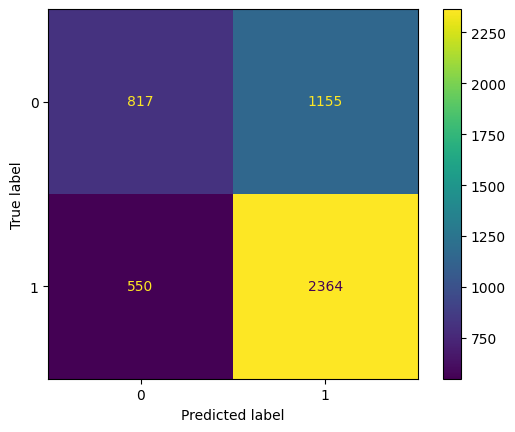

In [39]:
mnb = MultinomialNB()

model_expers(mnb, 'MultinomialNB')

BaggingClassifier
Training Score: 0.8664
Testing Score: 0.623 

Accuracy: 0.623
Specificity: 0.5081
Precision: 0.678
Recall: 0.7008
F1 Score: 0.6892 

Best accuracy rate confusion matrix:


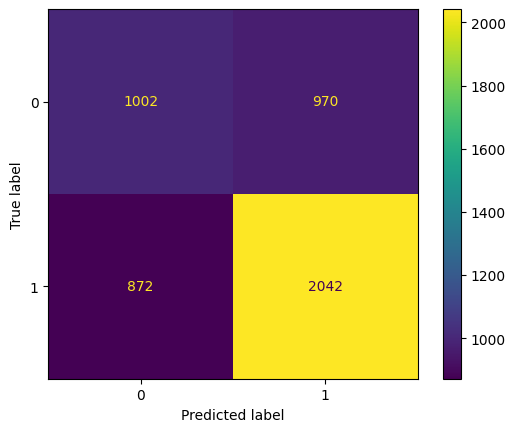

In [40]:
bag = BaggingClassifier()

model_expers(bag, 'BaggingClassifier')

Decision Tree
Training Score: 0.8805
Testing Score: 0.6017 

Accuracy: 0.6017
Specificity: 0.5025
Precision: 0.6652
Recall: 0.6688
F1 Score: 0.667 

Best accuracy rate confusion matrix:


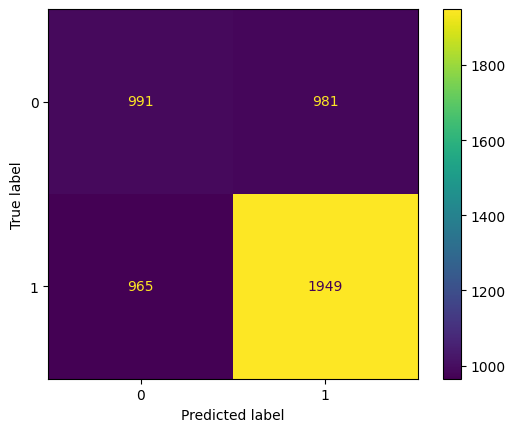

In [41]:
dtree = DecisionTreeClassifier(random_state=42)

model_expers(dtree, 'Decision Tree')

In [42]:
model_experiments_df

,model_used,train_score,test_score,accuracy,specificity,precision,recall,f1 score,true_neg,false_pos,false_neg,true_pos
0,Gradient Boosting,0.696008,0.676218,0.676218,0.534990,0.710360,0.771791,0.739803,1055,917,665,2249
1,Logistic Regression,0.680194,0.670078,0.670078,0.511663,0.701673,0.777282,0.737545,1009,963,649,2265
2,KNN,0.728915,0.631805,0.631805,0.512170,0.683449,0.712766,0.697799,1010,962,837,2077
3,Random Forest,0.880502,0.627916,0.627916,0.474645,0.672980,0.731640,0.701085,936,1036,782,2132
4,Ada Boost,0.688485,0.675808,0.675808,0.544625,0.712732,0.764585,0.737748,1074,898,686,2228
5,MultinomialNB,0.653634,0.651044,0.651044,0.414300,0.671782,0.811256,0.734960,817,1155,550,2364
6,BaggingClassifier,0.866428,0.623005,0.623005,0.508114,0.677955,0.700755,0.689166,1002,970,872,2042
7,Decision Tree,0.880502,0.601719,0.601719,0.502535,0.665188,0.668840,0.667009,991,981,965,1949


- All models aside from MNB scored worse on accuracy

**FINAL NOTES**
- TODO etc.
- The last notebook in the series is [Results and Recommendations](./04_results.ipynb).